# Introduction

This is a starter notebook provided by the hackathon

https://zindi.africa/competitions/giz-nlp-agricultural-keyword-spotter

This notebook is a quick introduction to the GIZ NLP Agricultural Keyword Spotter challenge on Zindi. We'll take a peek at the data, fit a quick (bad) model and make a submission. Let's get going!

# Getting Set Up

So I'd suggest uploading Train.csv and SampleSubmission.csv and then mounting your drive and copying in the files as shown here:

We'll also need a few libraries. Run these cells to install. You may then need to restart the runtime.

In [1]:
!pip install -q fastai fastcore --upgrade # Make sure we have the new version

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install -q python_speech_features

You should consider upgrading via the 'pip install --upgrade pip' command.


# First Look

This is an audio classification task, and it's a hard one! Each audio file is a recording of someone saying a key word or phrase. Let's look at the train file and listen to a few random samples

In [1]:
import pandas as pd
import IPython.display as ipd

In [2]:
train = pd.read_csv('Train.csv')
train.head()

,fn,label
0,audio_files/IV38R7F.wav,akawuka
1,audio_files/KM4SKWT.wav,banana
2,audio_files/F5POSU9.wav,obulwadde
3,audio_files/MMVDXG2.wav,nnyaanya
4,audio_files/9TVM96F.wav,pampu


In [3]:
train.shape

(1109, 2)

In [4]:
# Show a sample to listen to
ipd.Audio(train.fn.sample().values[0])

Our task is to predict which word is being spoken for some un-labeled recordings (the test set). To submit our predictions we much follow the submission format:

In [5]:
ss = pd.read_csv('SampleSubmission.csv')
ss.head()

,fn,maize streak virus,disease,okukkoola,muwogo,mpeke,mucungwa,greens,garden,mango,...,kasaanyi,suckers,insects,fertilizer,nakavundira,ekiwojjolo,akawuka,ddagala,ebiwojjolo,obutungulu
0,audio_files/00118N3.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,audio_files/00P0NMV.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,audio_files/01QEEZI.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,audio_files/037YAED.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,audio_files/0382N0Y.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


For each file we must submit probabilities - how likely we think it is that each keyword is the one being spoken in the audio file. Now, this sounds pretty easy (speech recognition has been around for a while) but what makes this harder is the dataset size - a constraint that is often encountered when dealing with languages other than English. The recordings are also fairly low quality. Let's see how many training examples we have for each word:

In [6]:
# Plot a histogram showing how common different counts are
train.groupby('label').count()['fn'].plot(kind='hist')

In [7]:
train.groupby('label').count()['fn'].min()

3

You can see that for many words we only have 3 or 4 training examples! And even the most common words only have 10 or 12 examples. Now, this will change: as the competition progresses we're hoping to get a bit more data from the project. But even so, your solution will need to get creative in terms of how you deal with this constraint.

# Where do we begin?

So how do we even think about approaching this sort of challenge? There are a few ways - here we'll show one of the most popular. We'll convert the audio files into a 2D image called a spectrogram, which shows the sound intensity at different frequencies over time. We'll use these image representations as the inputs to a neural network. This approach doesn't do very well out of the box here, but hopefully it's enough to get you thinking of better ideas!

To help us with this we'll use a few useful libraries:
- fastai to give us a powerful framework for deep learning
- librosa for audio processing

Let's start by making a function to turn an audio file into an image:

In [8]:
import librosa
import python_speech_features as psf
from matplotlib import pyplot as plt
import numpy as np

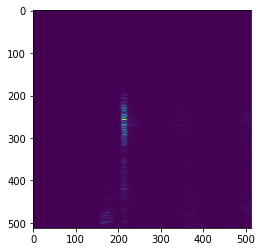

In [9]:
def im_from_audio(fn, sample_rate=44100, window_length=0.05, window_step=0.0045, NFFT=2205):
  
    # Load the audio into an array (signal) at the specified sample rate
    signal, sr = librosa.load(fn, sr=sample_rate)

    # preemphasis
    signal = psf.sigproc.preemphasis(signal, coeff=0.95)

    # get specrogram
    # Get the frames
    frames = psf.sigproc.framesig(signal, 
                                  window_length*sample_rate, 
                                  window_step*sample_rate, 
                                  lambda x:np.ones((x,)))        # Window function 

    # magnitude Spectrogram
    spectrogram = np.rot90(psf.sigproc.magspec(frames, NFFT))

    # get rid of high frequencies
    spectrogram = spectrogram[512:,:]

    # normalize in [0, 1]
    spectrogram -= spectrogram.min(axis=None)
    spectrogram /= spectrogram.max(axis=None)        

    # Clip to max 512, 512
    spectrogram = spectrogram[:512, :512]

    return spectrogram 

# View the resultant image
plt.imshow(im_from_audio(train.fn.sample().values[0]))

In [10]:
train.fn.sample().values[0]

'audio_files/B2MSSN4.wav'

In [11]:
# Check the shape. For some, we may need to pad to make the full 512 width
im_from_audio(train.fn.sample().values[0]).shape

(512, 512)

# Feeding this into fastai

You could save these spectrograms as images and use a library of your choice. But with fastai v2 we can use the datablock API to make a custom data loader that will read the audio file, create the spectrograms and prepare that for training:

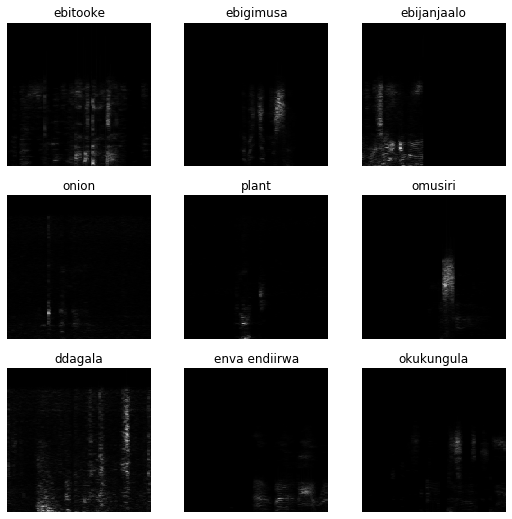

In [12]:
from fastai.vision.all import *

def get_x(fn):

    # Use our function from earlier
    spectrogram = im_from_audio(fn) # a 2D array

    # Pad to make sure it is 512 x 512
    w, h = spectrogram.shape
    spectrogram = np.pad(spectrogram, [(0, 512-w), (0, 512-h)])

    # Scale to (0, 255)
    spectrogram  -= spectrogram.min()
    spectrogram *= 255.0/spectrogram.max()

    # Make it uint8
    im_arr = np.array(spectrogram, np.uint8)

    # Make it rgb (hint - some fun tricks you can do here!)
    r = im_arr
    g = im_arr
    b = im_arr

    return np.stack([r, g, b], axis=-1)

def get_y(fn):
    return train.loc[train.fn == fn].label.values[0]

def get_fns(_):
    return train['fn']

# And build the datablock
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_fns,
    get_x=get_x,
    get_y=get_y, 
    splitter=RandomSplitter(valid_pct=0.1),
    batch_tfms=aug_transforms(do_flip=False, p_affine=0, size=224) # Augment with lighting changes but NOT flips or warps
)
dls = dblock.dataloaders(Path(''), bs=16)
dls.show_batch()

Look at that! Inputs and the associated outputs, a 10% validation set, resizing to a smaller size (224px) to speed up modelling... we're ready to train!

In [13]:
learn = cnn_learner(dls, resnet18, metrics=[accuracy, top_k_accuracy])
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/lavanyamk/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,6.997620,5.823086,0.027273,0.045455,04:26


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,5.684614,5.716091,0.027273,0.063636,06:10
1,4.962820,5.221719,0.045455,0.118182,06:31
2,4.154797,5.139942,0.045455,0.136364,05:29


# Saving Our Predictions

In [14]:
tdl = learn.dls.test_dl(ss['fn'].values, order=True) # Create a test dataloader
test_preds, test_labels = learn.get_preds(dl=tdl) # Make the predictions
test_preds[0] # Look at an example

tensor([5.7016e-04, 7.6456e-04, 3.1006e-03, 4.4177e-05, 2.5118e-04, 1.2653e-03,
        6.3765e-04, 5.2457e-03, 5.4307e-03, 8.4870e-03, 2.8230e-03, 1.6338e-04,
        3.2112e-04, 8.5594e-04, 1.6847e-04, 6.8226e-05, 2.0988e-02, 1.2058e-02,
        1.1427e-02, 1.9791e-03, 2.6176e-03, 1.9956e-03, 1.1517e-03, 9.0315e-04,
        1.0567e-02, 3.8384e-03, 6.2474e-04, 2.0946e-03, 1.1031e-04, 1.8277e-02,
        2.2377e-04, 1.1990e-02, 9.5482e-03, 1.1031e-04, 5.1430e-03, 1.3398e-03,
        4.4258e-04, 8.3320e-03, 2.0282e-03, 1.4926e-03, 7.7671e-04, 3.2178e-03,
        4.7068e-04, 1.4615e-03, 2.5143e-02, 2.1638e-03, 2.0414e-04, 2.0268e-04,
        5.6826e-04, 3.9691e-04, 1.8965e-02, 1.3305e-04, 8.8100e-05, 1.5300e-03,
        1.6399e-02, 9.5525e-05, 2.6206e-04, 1.7343e-03, 1.7749e-03, 2.0890e-03,
        1.0784e-02, 4.2751e-03, 2.4964e-03, 2.5126e-03, 2.8986e-04, 8.6720e-03,
        2.7470e-04, 6.2007e-04, 3.6635e-03, 5.5429e-03, 1.5262e-02, 9.0328e-03,
        4.7915e-03, 2.0618e-03, 4.0182e-

In [15]:
dls.vocab # The class names

(#193) ['Pump','Spinach','abalimi','afukirira','agriculture','akammwanyi','akamonde','akasaanyi','akatunda','akatungulu'...]

In [17]:
# Save the predictions in the required format
for i, label in enumerate(dls.vocab):
    ss[label] = [t[i].numpy() for t in test_preds]
ss.head()

,fn,maize streak virus,disease,okukkoola,muwogo,mpeke,mucungwa,greens,garden,mango,...,kasaanyi,suckers,insects,fertilizer,nakavundira,ekiwojjolo,akawuka,ddagala,ebiwojjolo,obutungulu
0,audio_files/00118N3.wav,0.0013799687,0.0182768,0.00015454658,0.00027969683,0.005038979,0.0020395096,0.00027611022,0.0087422645,0.019380612,...,0.0012060195,0.00078648084,4.2352265e-05,0.00073144067,0.0015400324,0.008672048,0.0028230231,0.0020946423,0.0005682562,0.00054681295
1,audio_files/00P0NMV.wav,0.0018188166,0.0013884245,0.0018146035,0.0015779628,0.0012856732,0.0010530327,0.0007602734,0.0021122221,0.00087594986,...,0.0040812623,0.0011585215,0.0004855158,0.0052873497,0.06241038,0.0044077127,0.036809515,0.035754826,0.0020629081,0.040264096
2,audio_files/01QEEZI.wav,0.0022359572,0.0024487271,0.0024012933,0.0019708956,0.013488627,0.0041052205,0.0025610977,0.002781122,0.0035117797,...,0.0014814332,0.0063748937,0.012605854,0.003296608,0.0028388395,0.0010606807,0.00044965115,0.0010314616,0.0065690554,0.0013074493
3,audio_files/037YAED.wav,0.004526994,0.00095950044,0.0030766497,0.0006658163,0.00018344689,0.0011306772,0.0044719367,0.013080149,0.0003732303,...,0.010799158,0.0010202896,0.0058959266,0.0074473415,0.0010189827,0.004171625,0.00053697795,0.011374336,0.0010818072,0.0008739097
4,audio_files/0382N0Y.wav,0.008736241,0.0029322777,0.0011484175,0.0077843666,0.0023066504,0.0055843387,0.00051898917,0.004453587,0.00086742465,...,0.0010449303,0.01945085,0.0036000346,0.00362704,0.009617501,0.0008697224,0.0070240465,0.0019167847,0.012896642,0.0028391161


In [18]:
ss.to_csv('Submission1.csv', index=False)

# Making it better

- Split sensibly - rather than a random split, consider splitting such that your validation set samples from each class.
- Rather than duplicating the spectrogram across the three channels, consider ways to make it more useful as a 3 channel image or just use a single channel network.
- Is using a network pre-trained on ImageNet really the best way to go?
- Better architectures, more training, test time augmentation can all give a score boost, but don't rely on these alone to get you to the top...
- This dataset is small. What if you used the network as a feature extractor and then used another method for classification instead?
- Look into what other folks doing audio classification have been doing - there are some really cool papers from the last year or two begging to be re-implemented.